In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))
plt.style.use('dark_background')

# numpy axis revision:


In [7]:
mat = np.arange(100).reshape(10 , 10)
mat , mat.sum(axis = 0) , mat.sum(axis = 1)

(array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]),
 array([450, 460, 470, 480, 490, 500, 510, 520, 530, 540]),
 array([ 45, 145, 245, 345, 445, 545, 645, 745, 845, 945]))

In [9]:
mat.mean(axis = 0) , mat.mean(axis = 1)

(array([45., 46., 47., 48., 49., 50., 51., 52., 53., 54.]),
 array([ 4.5, 14.5, 24.5, 34.5, 44.5, 54.5, 64.5, 74.5, 84.5, 94.5]))

# torch revision:


## implement attention:


In [11]:
import gensim.downloader
glove = gensim.downloader.load('glove-twitter-25')

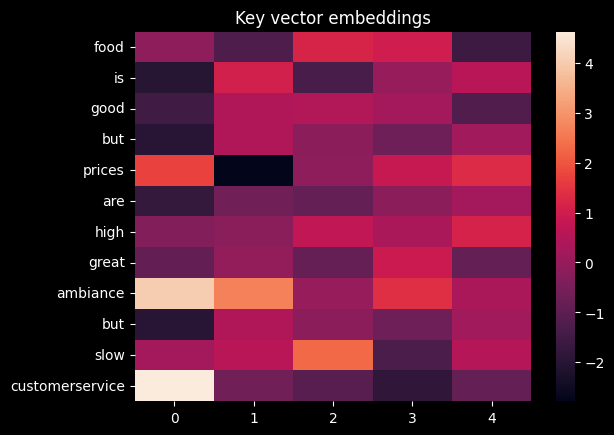

In [77]:
from sklearn.decomposition import PCA
import string

text = 'food is good but prices are high , great ambiance but slow customer-service!'
text = text.translate(text.maketrans('' , '' , string.punctuation))

words = text.split()
pca = PCA(n_components= 5)
tokens = [glove[word].tolist() for word in words]
key = pca.fit_transform(tokens)

kdf = pd.DataFrame(np.matrix(key) , index = words)
sns.heatmap(kdf)
plt.yticks(rotation = 0)
plt.title('Key vector embeddings')
plt.show()

self.attweights.shape=torch.Size([12, 12])
output.shape=torch.Size([12, 5])


<Axes: >

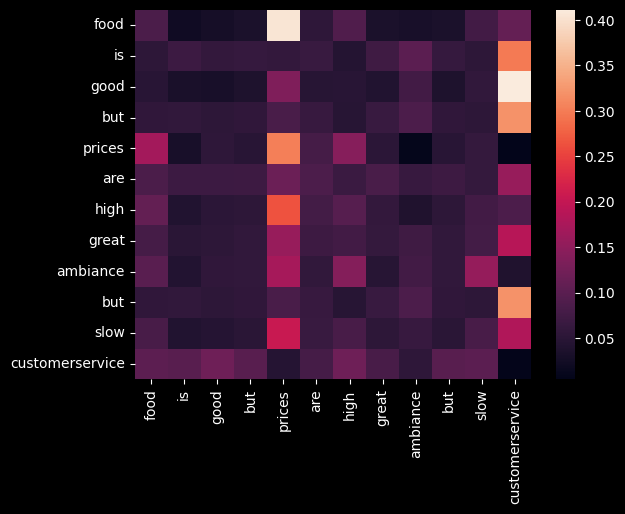

In [78]:
#attention layer:
class SelfAttention(nn.Module):
    #basic scaled dot product attention:
    def __init__(self , dmodel , dkey):
        super().__init__()
        self.dk = dkey
        self.wq = nn.Linear(dmodel , dkey)
        self.wk = nn.Linear(dmodel , dkey)
        self.wv = nn.Linear(dmodel , dkey)


    def forward(self , x):
        # x -> (batch , seq_len , dmodel)

        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)

        score = torch.matmul(q , k.T) / (self.dk ** 0.5)

        self.attweights = nn.functional.softmax(score , dim = 1)
        print(f'{self.attweights.shape=}')

        output = torch.matmul(self.attweights , v)
        print(f'{output.shape=}')
        return output
    

#demo
x = torch.tensor(key , dtype = torch.float32)
attention = SelfAttention(dmodel = 5 , dkey = 5)
out = attention(x)
attdf = pd.DataFrame(attention.attweights.detach().numpy() , columns = words , index = words)
sns.heatmap(attdf)

aweights.shape=torch.Size([1, 12])
output.shape=torch.Size([1, 5])


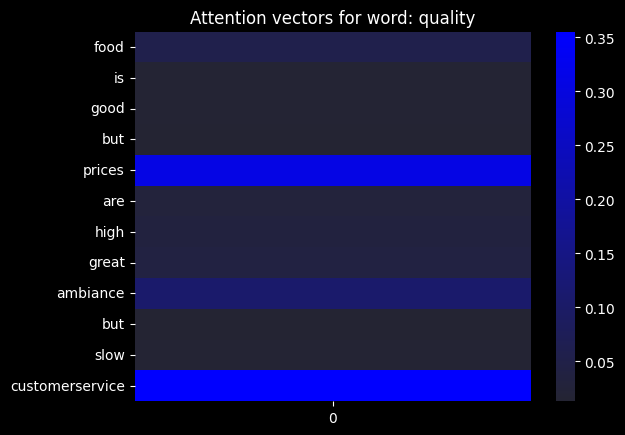

In [129]:
def selfattention(q , k , v):
    dk = k.shape[1]
    score = torch.matmul(q , k.T) / (dk ** 0.5)
    aweights = F.softmax(score , dim = 1)
    print(f'{aweights.shape=}')
    output = torch.matmul(aweights , v)
    print(f'{output.shape=}')
    return (aweights , output)


# x = x.reshape(7 , 5)
qtext = 'quality'
oqtext = qtext
qtext = qtext.translate(qtext.maketrans('' , '' , string.punctuation))
qtext = pca.transform(glove[qtext].reshape(1 , -1))
qtext = torch.tensor(qtext , dtype = torch.float32).reshape(1 , -1)
weights , output = selfattention(qtext , x, x)
sns.heatmap(weights.T , cmap = sns.dark_palette('blue' , as_cmap= True))
plt.yticks( np.arange(len(words)) + 0.5 , words , rotation = 0)
plt.title(f'Attention vectors for word: {oqtext}')
plt.show()

q.shape=torch.Size([12, 5]) , k.shape=torch.Size([12, 5])
score.shape=torch.Size([12, 12])
ascore.shape=torch.Size([12, 12])


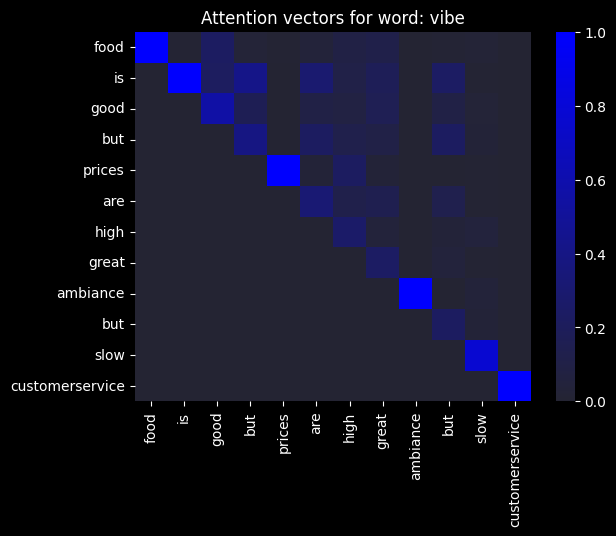

In [138]:
#function for masked self-attention:        the ones used in decoders!
def mattention(q , k , v):
    n , dk = k.shape
    print(f'{q.shape=} , {k.shape=}')
    score = (q @ k.T) / (dk ** 0.5)

    #add mask
    mask = torch.triu(torch.ones(score.shape) , diagonal= 1).bool()
    score = score.masked_fill(mask , float('-inf'))
    print(f'{score.shape=}')
    ascore = F.softmax(score , dim = 1)
    print(f'{ascore.shape=}')
    output = ascore @ v
    return (ascore , output)

qtext = 'vibe'
oqtext = qtext
qtext = qtext.translate(qtext.maketrans('' , '' , string.punctuation))
qtext = pca.transform(glove[qtext].reshape(1 , -1))
qtext = torch.tensor(qtext , dtype = torch.float32).reshape(1 , -1)
weights , output = mattention(x , x, x)
sns.heatmap(weights.T , cmap = sns.dark_palette('blue' , as_cmap= True))
plt.xticks( np.arange(len(words)) + 0.5 , words , rotation = 90)
plt.yticks( np.arange(len(words)) + 0.5 , words , rotation = 0)
plt.title(f'Attention vectors for word: {oqtext}')
plt.show()